# **[MC906] Projeto Final**: Detecção de Desastres

O objetivo desse projeto é construir e avaliar modelos de aprendizado de máquina que classifiquem quais Tweets são sobre desastres reais e quais não são.

## **Acessar Diretório do Projeto**

Esse Notebook assume que você está executando o código dentro da pasta `Projeto Final/Código`, que contém todos os códigos fontes relativos a esse trabalho. Para acessar o diretório no Colab é preciso criar um atalho em seu Drive (right click no diretório -> "Adicionar atalho ao Google Drive") e executar as células abaixo:

In [ ]:
# Conectar ao Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Diretório do Projeto (/content/drive/My Drive/{path até Projeto Final/Código}), 
# dependendo da onde se localiza o atalho no seu Drive
% cd '/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código'
! ls

/content/drive/.shortcut-targets-by-id/1HmHC25ZqX3hUlCsRT-S0qiSsjwf10jLn/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código
'Attention CNN'			 Modelos
 BERT				 __pycache__
'Convolutional Neural Network'	'Quasi-Recurrent Networks'
'Dense Neural Networks'		'Recurrent Neural Networks'
'Logistic Regression'		 tokenization.py
'Melhor Pré-Processamento'	 utils.py


## **Dependências:**

In [ ]:
# Imports de pacotes instalados
from os.path import join, exists
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Input, Attention, Dense, Activation, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Imports locais
from utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Dataset:**

Utilizamos um *dataset* disponível no site [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (em inglês). Cada tweet apresenta três atributos: seu conteúdo (`text`), uma palavra-chave (`keyword`, opcional) e a localização da onde foi enviado (`location`, opcional). Como só usaremos o texto, removemos os dois últimos.

In [ ]:
# Ler e limpar dados (removendo colunas do id, keyword e location)
train = pd.read_csv("../Dataset/train.csv")
train = train.drop(['id','keyword','location'], axis=1)

# Imprimir alguns dados
print(train.head())
vals = train.groupby('target').count()
print("\nSome General insights:")
print(f"Figure of Speech: {vals.iloc[0]['text']*100/len(train):.2f}%")
print(f"Actual Accidents: {vals.iloc[1]['text']*100/len(train):.2f}%")

# Salvar targets
Y = np.array([[x] for x in train.target.tolist()])

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Some General insights:
Figure of Speech: 57.03%
Actual Accidents: 42.97%


## **Pré-Processamento:**

*Global Vectors for Word Representation*, ou GloVe, é um algoritmo de aprendizado não-supervisionado com o objetivo de obter representações vetoriais para palavras, proposto em 2014. O algoritmo mapeia as palavras no espaço, tal que a distância e a semelhança semântica entre elas é proporcional.

Utilizamos sua representação de palavras para nosso conjunto de dados e seus pesos pré-treinados na camada de Embedding da rede, mais especificamente o arquivo *glove.840B.300d.txt*. Previamente, também removemos as pontuações e caracteres especiais dos textos.

In [ ]:
# Limpar texto 
train.text = train.text.apply(clean_up)

In [ ]:
# Aplicar tokenização
max_words = 20000
max_length = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.text)
X = tokenizer.texts_to_sequences(train.text)
print(X[1])
X = pad_sequences(X, maxlen=max_length)
print(X[1])

[176, 44, 214, 647, 6630, 6631, 1327]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  176   44  214  647 6630 6631 1327]


In [ ]:
# Preparar incorporação de palavras
embeddings_index = dict()
f = open('../Glove/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
      float(values[1])
    except ValueError:
      continue
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# Construir matriz de incorporação
embedding_matrix = np.zeros((max_words, 300))
for word, index in tokenizer.word_index.items():
    if index > max_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

## **Modelo:** Rede Quasi-Recorrente

Um método alternativo que resolvemos testar foi o de redes "quasi-recorrentes", tanto sem quanto com atenção.

## **Camada QRNN**:
Como não há implementação de uma camada Quasi-Recorrente no *Tensorflow*, foi utilizada uma implementação externa, criada pelo usuário Bilal ML e disponibilizada no site *Kaggle* a partir deste [link](https://www.kaggle.com/bkkaggle/keras-quasi-recurrent-neural-network).

A integração da camada no *Tensorflow 2.0* foi simples, apenas necessitando do porte de uma função que não está presente na nova versão, chamada de *conv_output_length*. A função utilizada foi retirada de uma versão antiga da biblioteca *Keras*.

In [ ]:
def conv_output_length(input_length, filter_size, padding, stride, dilation=1):
  """Determines output length of a convolution given input length.
  Arguments:
      input_length: integer.
      filter_size: integer.
      padding: one of "same", "valid", "full", "causal"
      stride: integer.
      dilation: dilation rate, integer.
  Returns:
      The output length (integer).
  """
  if input_length is None:
    return None
  assert padding in {'same', 'valid', 'full', 'causal'}
  dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
  if padding in ['same', 'causal']:
    output_length = input_length
  elif padding == 'valid':
    output_length = input_length - dilated_filter_size + 1
  elif padding == 'full':
    output_length = input_length + dilated_filter_size - 1
  return (output_length + stride - 1) // stride

def _dropout(x, level, noise_shape=None, seed=None):
    x = K.dropout(x, level, noise_shape, seed)
    x *= (1. - level) # compensate for the scaling by the dropout
    return x

class QRNN(Layer):
    '''Quasi RNN
    # Arguments
        units: dimension of the internal projections and the final output.
    # References
        - [Quasi-recurrent Neural Networks](http://arxiv.org/abs/1611.01576)
    '''
    def __init__(self, units, window_size=2, stride=1,
                 return_sequences=False, go_backwards=False, 
                 stateful=False, unroll=False, activation='tanh',
                 kernel_initializer='uniform', bias_initializer='zero',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, 
                 dropout=0, use_bias=True, input_dim=None, input_length=None,
                 **kwargs):
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.units = units 
        self.window_size = window_size
        self.strides = (stride, 1)

        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = dropout
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]
        self.input_dim = input_dim
        self.input_length = input_length
        if self.input_dim:
            kwargs['input_shape'] = (self.input_length, self.input_dim)
        super(QRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec = InputSpec(shape=(batch_size, None, self.input_dim))
        self.state_spec = InputSpec(shape=(batch_size, self.units))

        self.states = [None]
        if self.stateful:
            self.reset_states()

        kernel_shape = (self.window_size, 1, self.input_dim, self.units * 3)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                        shape=(self.units * 3,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        length = input_shape[1]
        if length:
            length = conv_output_length(length + self.window_size - 1,
                                        self.window_size, 'valid',
                                        self.strides[0])
        if self.return_sequences:
            return (input_shape[0], length, self.units)
        else:
            return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask):
        if self.return_sequences:
            return mask
        else:
            return None

    def get_initial_states(self, inputs):
        # build an all-zero tensor of shape (samples, units)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
        initial_state = K.tile(initial_state, [1, self.units])  # (samples, units)
        initial_states = [initial_state for _ in range(len(self.states))]
        return initial_states

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        if not self.input_spec:
            raise RuntimeError('Layer has never been called '
                               'and thus has no states.')

        batch_size = self.input_spec.shape[0]
        if not batch_size:
            raise ValueError('If a QRNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a '
                             '`batch_shape` argument to your Input layer.')

        if self.states[0] is None:
            self.states = [K.zeros((batch_size, self.units))
                           for _ in self.states]
        elif states is None:
            for state in self.states:
                K.set_value(state, np.zeros((batch_size, self.units)))
        else:
            if not isinstance(states, (list, tuple)):
                states = [states]
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 'state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if value.shape != (batch_size, self.units):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, self.units)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def __call__(self, inputs, initial_state=None, **kwargs):
        # If `initial_state` is specified,
        # and if it a Keras tensor,
        # then add it to the inputs and temporarily
        # modify the input spec to include the state.
        if initial_state is not None:
            if hasattr(initial_state, '_keras_history'):
                # Compute the full input spec, including state
                input_spec = self.input_spec
                state_spec = self.state_spec
                if not isinstance(state_spec, list):
                    state_spec = [state_spec]
                self.input_spec = [input_spec] + state_spec

                # Compute the full inputs, including state
                if not isinstance(initial_state, (list, tuple)):
                    initial_state = [initial_state]
                inputs = [inputs] + list(initial_state)

                # Perform the call
                output = super(QRNN, self).__call__(inputs, **kwargs)

                # Restore original input spec
                self.input_spec = input_spec
                return output
            else:
                kwargs['initial_state'] = initial_state
        return super(QRNN, self).__call__(inputs, **kwargs)

    def call(self, inputs, mask=None, initial_state=None, training=None):
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            initial_states = inputs[1:]
            inputs = inputs[0]
        elif initial_state is not None:
            pass
        elif self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(inputs)

        if len(initial_states) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_states)) +
                             ' initial states.')
        input_shape = K.int_shape(inputs)
        if self.unroll and input_shape[1] is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')
        constants = self.get_constants(inputs, training=None)
        preprocessed_input = self.preprocess_input(inputs, training=None)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                            initial_states,
                                            go_backwards=self.go_backwards,
                                            mask=mask,
                                            constants=constants,
                                            unroll=self.unroll,
                                            input_length=input_shape[1])
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        # Properly set learning phase
        if 0 < self.dropout < 1:
            last_output._uses_learning_phase = True
            outputs._uses_learning_phase = True

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def preprocess_input(self, inputs, training=None):
        if self.window_size > 1:
            inputs = K.temporal_padding(inputs, (self.window_size-1, 0))
        inputs = K.expand_dims(inputs, 2)  # add a dummy dimension

        output = K.conv2d(inputs, self.kernel, strides=self.strides,
                          padding='valid',
                          data_format='channels_last')
        output = K.squeeze(output, 2)  # remove the dummy dimension
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.dropout is not None and 0. < self.dropout < 1.:
            z = output[:, :, :self.units]
            f = output[:, :, self.units:2 * self.units]
            o = output[:, :, 2 * self.units:]
            f = K.in_train_phase(1 - _dropout(1 - f, self.dropout), f, training=training)
            return K.concatenate([z, f, o], -1)
        else:
            return output

    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        output = f * prev_output + (1 - f) * z
        output = o * output

        return output, [output]

    def get_constants(self, inputs, training=None):
        return []
 
    def get_config(self):
        config = {'units': self.units,
                  'window_size': self.window_size,
                  'stride': self.strides[0],
                  'return_sequences': self.return_sequences,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll,
                  'use_bias': self.use_bias,
                  'dropout': self.dropout,
                  'activation': activations.serialize(self.activation),
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'input_dim': self.input_dim,
                  'input_length': self.input_length}
        base_config = super(QRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### **Rede 1**: QRNN sem atenção

In [ ]:
def QRNN_glove(max_words = max_words, max_len = X.shape[1], qrnn_out=256):
  ''' Função que constrói o modelo QRNN sem atenção. '''

  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 300, input_length=50, weights=[embedding_matrix], trainable=False)(inputs)
  layer = QRNN(qrnn_out, window_size=3, dropout=0.2, return_sequences=True,
            kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3), 
            kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10))(layer)
  avg_pool = GlobalAveragePooling1D()(layer)
  max_pool = GlobalMaxPooling1D()(layer)
  conc = concatenate([avg_pool, max_pool])
  layer = Dense(1,name='out_layer')(conc)
  layer = Activation('sigmoid')(layer)
  model_glove = Model(inputs=inputs,outputs=layer)
  return model_glove

In [ ]:
# Construir e compilar modelo
qrnn = QRNN_glove()
qrnn.summary()
qrnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      6000000     inputs[0][0]                     
__________________________________________________________________________________________________
qrnn_2 (QRNN)                   (None, 50, 256)      691968      embedding_2[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 256)          0           qrnn_2[0][0]                     
_______________________________________________________________________________________

In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_QRNN_glove.h5', save_best_only=True)]
QRNN_history = qrnn.fit(X,Y,batch_size=100,epochs=15, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_QRNN.h5'):
    neural_network = load_model('./Modelos/best_model_QRNN.h5')

Epoch 1/15
69/69 [==============================] - 11s 165ms/step - loss: 0.7872 - accuracy: 0.7824 - val_loss: 0.6093 - val_accuracy: 0.8031
Epoch 2/15
69/69 [==============================] - 10s 151ms/step - loss: 0.5182 - accuracy: 0.8346 - val_loss: 0.5555 - val_accuracy: 0.8123
Epoch 3/15
69/69 [==============================] - 10s 152ms/step - loss: 0.4564 - accuracy: 0.8535 - val_loss: 0.6205 - val_accuracy: 0.7703
Epoch 4/15
69/69 [==============================] - 10s 145ms/step - loss: 0.4163 - accuracy: 0.8695 - val_loss: 1.3441 - val_accuracy: 0.7874
Epoch 5/15
69/69 [==============================] - 10s 145ms/step - loss: 0.3806 - accuracy: 0.8969 - val_loss: 0.6741 - val_accuracy: 0.8018
Epoch 6/15
69/69 [==============================] - 10s 144ms/step - loss: 0.3582 - accuracy: 0.9123 - val_loss: 0.9540 - val_accuracy: 0.8018
Epoch 7/15
69/69 [==============================] - 10s 145ms/step - loss: 0.3453 - accuracy: 0.9225 - val_loss: 0.9258 - val_accuracy: 0.7874

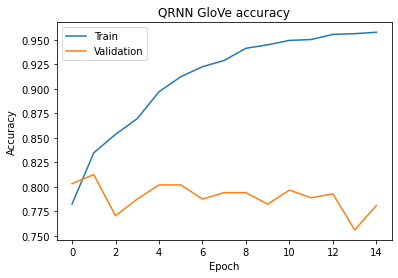

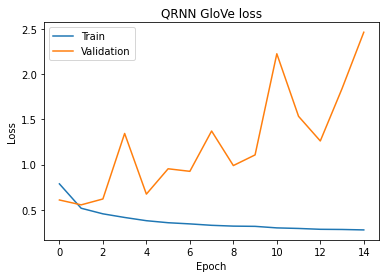

In [ ]:
# Plotar métricas
plot_graphs(QRNN_history, "QRNN GloVe")

### **Rede 2:** QRNN com atenção

In [ ]:
def QRNN_att(max_words = max_words, max_len = X.shape[1], qrnn_out=256):
  ''' Função que constrói o modelo QRNN com atenção. '''

  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 300, input_length=50, weights=[embedding_matrix], trainable=False)(inputs)
  layer = QRNN(qrnn_out, window_size=3, dropout=0.2, return_sequences=True,
               kernel_regularizer=l2(1e-3), bias_regularizer=l2(1e-3), 
               kernel_constraint=MaxNorm(10), bias_constraint=MaxNorm(10))(layer)
  att_layer = Attention()([layer,layer])
  avg_pool = GlobalAveragePooling1D()(layer)
  max_pool = GlobalMaxPooling1D()(att_layer)
  conc = concatenate([avg_pool, max_pool])
  layer = Dense(1,name='out_layer')(conc)
  layer = Activation('sigmoid')(layer)
  model_att = Model(inputs=inputs,outputs=layer)
  return model_att

In [ ]:
# Construir e compilar modelo
qrnn_att = QRNN_att()
qrnn_att.summary()
qrnn_att.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 300)      6000000     inputs[0][0]                     
__________________________________________________________________________________________________
qrnn_5 (QRNN)                   (None, 50, 256)      691968      embedding_5[0][0]                
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 50, 256)      0           qrnn_5[0][0]                     
                                                                 qrnn_5[0][0]         

In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_QRNN_att.h5', save_best_only=True)]
qrnn_att_history = qrnn_att.fit(X,Y,batch_size=100,epochs=5, validation_split=0.1, callbacks=callbacks)

Epoch 1/5
69/69 [==============================] - 11s 162ms/step - loss: 0.7893 - accuracy: 0.7745 - val_loss: 0.5991 - val_accuracy: 0.8058
Epoch 2/5
69/69 [==============================] - 10s 152ms/step - loss: 0.5186 - accuracy: 0.8359 - val_loss: 0.5533 - val_accuracy: 0.8136
Epoch 3/5
69/69 [==============================] - 10s 149ms/step - loss: 0.4490 - accuracy: 0.8567 - val_loss: 0.5499 - val_accuracy: 0.8097
Epoch 4/5
69/69 [==============================] - 10s 151ms/step - loss: 0.4061 - accuracy: 0.8726 - val_loss: 0.5666 - val_accuracy: 0.8045
Epoch 5/5
69/69 [==============================] - 10s 143ms/step - loss: 0.3823 - accuracy: 0.8875 - val_loss: 0.5659 - val_accuracy: 0.8110


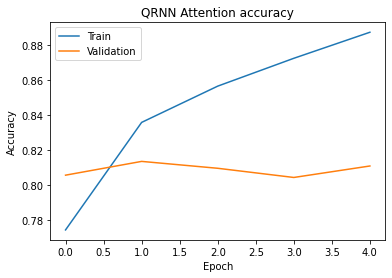

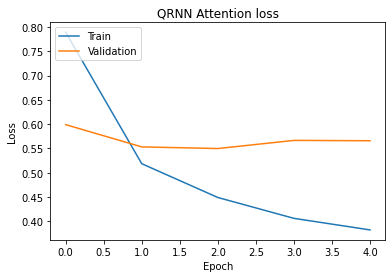

In [ ]:
# Plotar métricas
plot_graphs(qrnn_att_history, "QRNN Attention")